# Micrograd

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
class Value:
    def __init__(self, data, _children=(), _op=' ', label= ' '):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

        self.label = label

    def __repr__(self):
        return f"Value({self.data=})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
# before implementation of wrapper
a = Value(2.0)
a + 1

AttributeError: 'int' object has no attribute 'data'

In [20]:
a = Value(2.0)

In [15]:
a + 1

Value(self.data=3.0)

In [17]:
a * 3

Value(self.data=6.0)

In [18]:
3 * a

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

```
a * 2 = a.__mul__(2)

2 * a = 2.__mul__(a)
```

In [21]:
3 * a

Value(self.data=6.0)

```
a / b =
a * (1/b) =
a * (b ** -1)
```

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [29]:
# def init():
#     x1 = Value(2.0, label='x1')
#     x2 = Value(0.0, label='x2')
#     w1 = Value(-3.0, label='w1')
#     w2 = Value(1.0, label='w2')
#     b = Value(6.8813735870195432, label='b')

#     x1w1 = x1*w1; x1w1.label = 'x1w1'
#     x2w2 = x2*w2; x2w2.label = 'x2w2'
#     x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
#     n = x1w1x2w2 + b; n.label = 'n'
#     o = n.tanh(); o.label = 'o'
#     return o

In [32]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

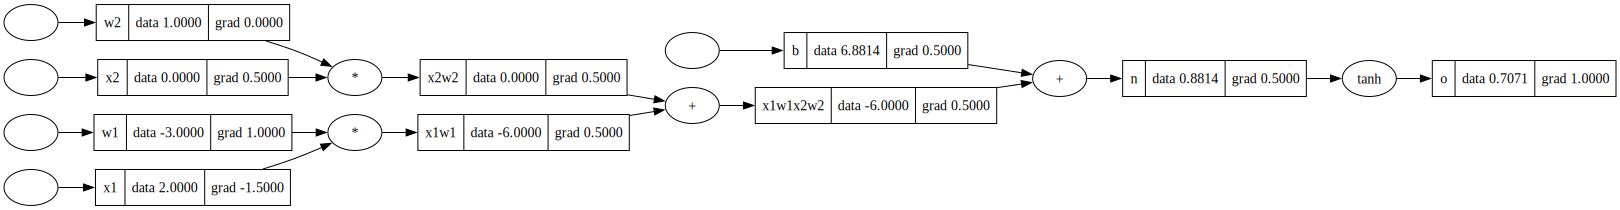

In [33]:
o.backward()
draw_dot(o)

In [38]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

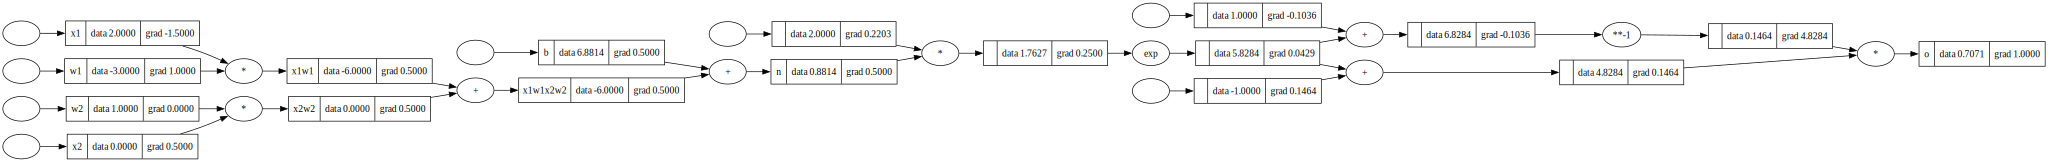

In [39]:
o.backward()
draw_dot(o)

In [19]:
import torch
import random

In [10]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(f"{o.data.item()=}")
print(f"{o.data=}")
print(f"{o=}")
o.backward()

print('---')
print(f'{x2.grad.item()=}')
print(f'{w2.grad.item()=}')
print(f'{x1.grad.item()=}')
print(f'{x1.grad=}')
print(f'{x1=}')

o.data.item()=0.7071066904050358
o.data=tensor([0.7071], dtype=torch.float64)
o=tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
---
x2.grad.item()=0.5000001283844369
w2.grad.item()=0.0
x1.grad.item()=-1.5000003851533106
x1.grad=tensor([-1.5000], dtype=torch.float64)
x1=tensor([2.], dtype=torch.float64, requires_grad=True)


In [47]:
x = torch.Tensor([[1,2,3], [4,5,6]])
print(x)
print(x.shape)
x.dtype

tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])


torch.float32

In [49]:
y = x.double()
print(y)
y.dtype

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)


torch.float64

In [78]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [79]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [88]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [81]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(self.data=-0.6334088041010126)

In [82]:
n.parameters()

[Value(self.data=-0.7653063114273151),
 Value(self.data=0.5401798016851747),
 Value(self.data=-0.8370153228955888)]

In [83]:
nl = Layer(2, 3)
nl(x)

[Value(self.data=0.9150555834820192),
 Value(self.data=0.9764484952448639),
 Value(self.data=0.7875790644028046)]

In [84]:
nl.parameters()

[Value(self.data=-0.2692963813083771),
 Value(self.data=0.7488488626704399),
 Value(self.data=-0.15020142177498275),
 Value(self.data=0.2224405218155463),
 Value(self.data=0.3104794756757423),
 Value(self.data=0.8386140839547895),
 Value(self.data=0.408387592632363),
 Value(self.data=0.37654181014048027),
 Value(self.data=-0.8813767886504056)]

In [89]:
x = [2.0, 3.0, -1.0]
mnn = MLP(3, [4, 4, 1])
y= mnn(x)
y

Value(self.data=-0.9213122424945606)

In [93]:
print(len(mnn.parameters()))
mnn.parameters()

41


[Value(self.data=0.7540184737623505),
 Value(self.data=-0.6765353735959416),
 Value(self.data=0.8904257016383494),
 Value(self.data=0.46519877834802315),
 Value(self.data=-0.11956918732025268),
 Value(self.data=-0.4067295532326951),
 Value(self.data=0.3766565430042561),
 Value(self.data=-0.008223687356877285),
 Value(self.data=0.22810062954428334),
 Value(self.data=-0.23921022886511611),
 Value(self.data=-0.782665069977335),
 Value(self.data=-0.468589867317208),
 Value(self.data=0.6303312686959301),
 Value(self.data=-0.1206074076293262),
 Value(self.data=-0.7355292391644186),
 Value(self.data=-0.519352152344025),
 Value(self.data=-0.8695776749834798),
 Value(self.data=-0.3948779224634069),
 Value(self.data=-0.2733527919168648),
 Value(self.data=0.815168481922028),
 Value(self.data=0.08923552704877746),
 Value(self.data=-0.8622505423752638),
 Value(self.data=0.9719082666895735),
 Value(self.data=-0.31465476938955694),
 Value(self.data=-0.848675854172058),
 Value(self.data=0.275953757307

In [ ]:
# draw_dot(y)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [mnn(x) for x in xs]
ypred

[Value(self.data=-0.9213122424945606),
 Value(self.data=-0.8882876565160815),
 Value(self.data=-0.2014488115530068),
 Value(self.data=-0.9064383777665471)]

In [96]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(self.data=3.691440733159477),
 Value(self.data=0.012479647686668977),
 Value(self.data=0.6376840005701051),
 Value(self.data=3.6345072882211436)]

In [97]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(self.data=7.976111669637396)

In [ ]:
# draw_dot(loss)

In [429]:
loss.backward()

In [430]:
# draw_dot(loss)

In [431]:
lr = -0.6

for p in mnn.parameters():
    p.data += lr * p.grad
    p.grad = 0.0

In [432]:
ypred = [mnn(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(self.data=0.0013751962100975422)

In [433]:
ypred

[Value(self.data=0.9815976629182176),
 Value(self.data=-0.9888581638212687),
 Value(self.data=-0.9809468348132653),
 Value(self.data=0.9765610029446797)]

In [476]:
mnn = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mnn(x) for x in xs]
print(ypred)


[Value(self.data=0.5365504064931358), Value(self.data=0.2930361374562769), Value(self.data=0.2951129933021493), Value(self.data=0.17561536640708286)]


In [491]:
lr = 0.4

for k in range(2000):

    # print (ypred)

    # Forward pass
    ypred = [mnn(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(loss)

    # Backward pass
    for p in mnn.parameters():
        p.grad = 0.0
    loss.backward()

    # Gradient descent
    for p in mnn.parameters():
        p.data -= lr * p.grad

    # ypred = [mnn(x) for x in xs]
    # print (ypred)


Value(self.data=3.157912499120459e-05)
Value(self.data=3.156194214520221e-05)
Value(self.data=3.154477778556728e-05)
Value(self.data=3.1527631882601566e-05)
Value(self.data=3.151050440667216e-05)
Value(self.data=3.1493395328211686e-05)
Value(self.data=3.147630461771408e-05)
Value(self.data=3.1459232245733744e-05)
Value(self.data=3.144217818289266e-05)
Value(self.data=3.1425142399873494e-05)
Value(self.data=3.140812486742108e-05)
Value(self.data=3.1391125556340517e-05)
Value(self.data=3.1374144437501633e-05)
Value(self.data=3.135718148183826e-05)
Value(self.data=3.134023666033786e-05)
Value(self.data=3.132330994405997e-05)
Value(self.data=3.13064013041177e-05)
Value(self.data=3.12895107116882e-05)
Value(self.data=3.1272638138013156e-05)
Value(self.data=3.1255783554385436e-05)
Value(self.data=3.1238946932171965e-05)
Value(self.data=3.1222128242787964e-05)
Value(self.data=3.120532745771743e-05)
Value(self.data=3.1188544548501716e-05)
Value(self.data=3.1171779486740423e-05)
Value(self.data

In [492]:
print(ypred)

[Value(self.data=0.9982813020655353), Value(self.data=-0.9980834531819399), Value(self.data=-0.9978676743254087), Value(self.data=0.9980303219332448)]
